- [Load dataset](#Load-dataset)
- [The Default data set](#Figure-4.1---Default-data-set)
- [4.3 Logistic Regression](#4.3-Logistic-Regression)
- [4.4 Linear Discriminant Analysis](#4.4-Linear-Discriminant-Analysis)

# Chapter 4 - Classification

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

/Users/yuany/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load dataset

In [2]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Data/Default.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

  default student      balance        income  default2  student2
1      No      No   729.526495  44361.625074         0         0
2      No     Yes   817.180407  12106.134700         0         1
3      No      No  1073.549164  31767.138947         0         0

## 4.3 Logistic Regression
### Figure 4.2

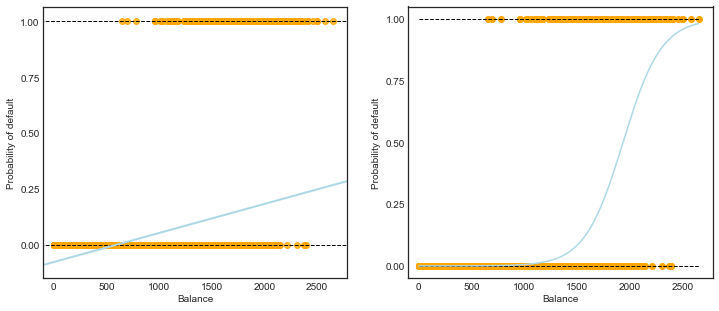

In [3]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot: Linear Regression
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot: Logistic Regression
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

### Table 4.1

In [4]:
y = df.default2

#####  scikit-learn

In [5]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
classes:  [0 1]
coefficients:  [[ 0.00549891]]
intercept : [-10.65131887]


##### statsmodels

In [6]:
X_train = sm.add_constant(df.balance)
est = smf.Logit(y.ravel(), X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


###  Table 4.2

In [7]:
X_train = sm.add_constant(df.student2)
y = df.default2

est = smf.Logit(y, X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student2,0.4049,0.115,3.520,0.000,0.179,0.630


###  Table 4.3 - Multiple Logistic Regression

In [8]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smf.Logit(y, X_train).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,3.033e-06,8.2e-06,0.370,0.712,-1.3e-05,1.91e-05
student2,-0.6468,0.236,-2.738,0.006,-1.110,-0.184


### Figure 4.3 - Confounding

In [9]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [10]:
df.groupby(['student','default']).size().unstack('default')

default    No  Yes
student           
No       6850  206
Yes      2817  127

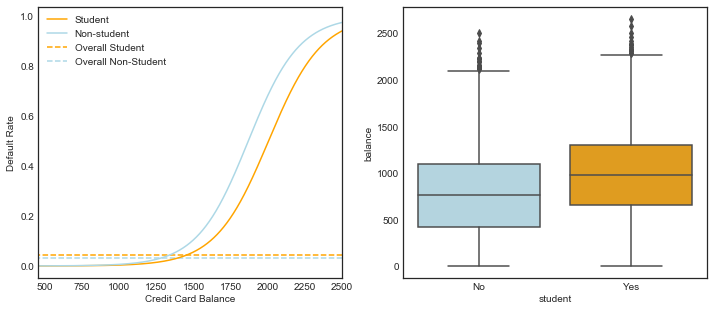

In [11]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

c_palette = {'No':'lightblue', 'Yes':'orange'}

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);

## 4.4 Linear Discriminant Analysis
### Table 4.4 


In [12]:
X = df[['balance', 'income', 'student2']].as_matrix()
y = df.default2.as_matrix()

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status         No  Yes
Predicted default status           
No                        9645  254
Yes                         22   79

That stands for [['TN', 'FN'],['FP','TP']].

In [13]:
# Show confusion_matrix 
cm = confusion_matrix(y, y_pred)
print(cm.T)

[[9645  254]
 [  22   79]]


In [14]:
def plot_confusion_matrix(cm, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

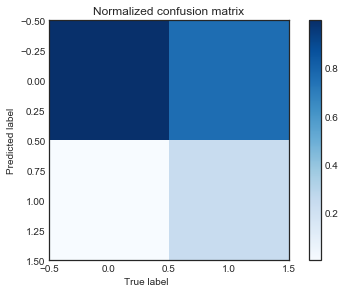

In [15]:
cm = confusion_matrix(y, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized.T)

In [16]:
print(classification_report(y, y_pred, target_names=['No', 'Yes'], digits=3))

             precision    recall  f1-score   support

         No      0.974     0.998     0.986      9667
        Yes      0.782     0.237     0.364       333

avg / total      0.968     0.972     0.965     10000



where 
- precision = 1 -  false discovery rate = TP/P* = TP/(TP+FP)
- recall = sensitivity = power = 1 - Type II error = TP/P = TP/(TP+FN)
- [f1-score = 2*((precision*recall)/(precision+recall))](# https://en.wikipedia.org/wiki/F1_score)

### Table 4.5
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [17]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status         No  Yes
Predicted default status           
No                        9435  140
Yes                        232  193

In [18]:
# Check confusion matrix 
cm = confusion_matrix(y, y_prob[:,1] > decision_prob)
print(cm.T)

[[9435  140]
 [ 232  193]]


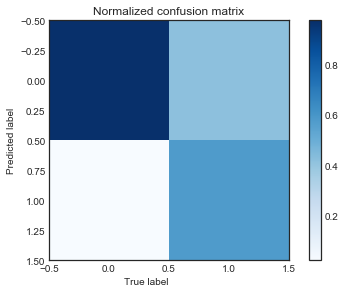

In [19]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized.T)

In [20]:
print(classification_report(y, y_prob[:,1] > decision_prob, target_names=['No', 'Yes'], digits=3))

             precision    recall  f1-score   support

         No      0.985     0.976     0.981      9667
        Yes      0.454     0.580     0.509       333

avg / total      0.968     0.963     0.965     10000



### Logistic Regression with scikit-learn

In [21]:
regr = skl_lm.LogisticRegression()
regr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
pred = regr.predict(X)
cm_log = confusion_matrix(y, pred)
cm_df = pd.DataFrame(cm_log.T, index=regr.classes_,
                     columns=regr.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True          0    1
Predicted           
0          9664  333
1             3    0


In [23]:
pred_p = regr.predict_proba(X)
cm_df = pd.DataFrame({'True': y, 'Pred': pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y, pred_p[:,1] > .25))

Pred    No  Yes
True           
0     9371  296
1      306   27
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      9667
          1       0.08      0.08      0.08       333

avg / total       0.94      0.94      0.94     10000



In [24]:
# Remove the 'income' predictor
X = df[['balance', 'student2']].as_matrix()
y = df.default2.as_matrix()

regr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
pred2 = regr.predict(X)
cm_log = confusion_matrix(y, pred2)
cm_df = pd.DataFrame(cm_log.T, index=regr.classes_,
                     columns=regr.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True          0    1
Predicted           
0          9639  243
1            28   90


In [26]:
pred_p2 = regr.predict_proba(X)
cm_df = pd.DataFrame({'True': y, 'Pred': pred_p2[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y, pred_p2[:,1] > .25))

Pred    No  Yes
True           
0     9490  177
1      155  178
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      9667
          1       0.50      0.53      0.52       333

avg / total       0.97      0.97      0.97     10000



In [27]:
### ROC Curves 

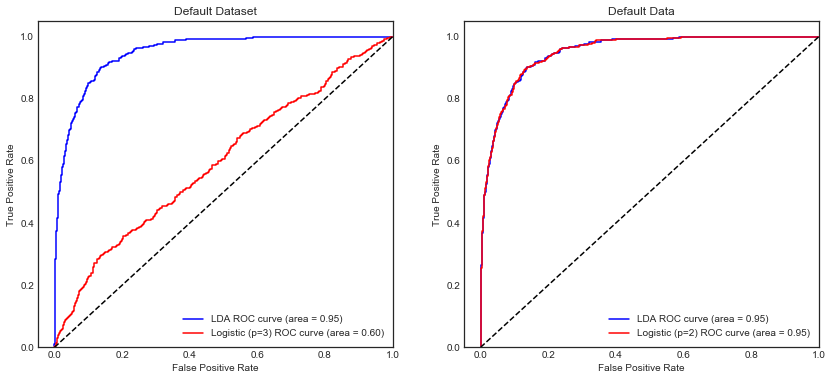

In [28]:
# ROC curve of LDA
false_pos_rate1, true_pos_rate1, _ = roc_curve(y, y_prob[:,1])
roc_auc1 = auc(false_pos_rate1, true_pos_rate1)

# ROC curve of Logistic Regression with 3 predictors
false_pos_rate2, true_pos_rate2, _ = roc_curve(y, pred_p[:,1])
roc_auc2 = auc(false_pos_rate2, true_pos_rate2)

# ROC curve of Logistic Regression with 2 predictors
false_pos_rate3, true_pos_rate3, _ = roc_curve(y, pred_p2[:,1])
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rate1, true_pos_rate1, label='LDA ROC curve (area = %0.2f)' % roc_auc1, color='b')
ax1.plot(false_pos_rate2, true_pos_rate2, label='Logistic (p=3) ROC curve (area = %0.2f)' % roc_auc2, color='r')
ax1.set_title('Default Dataset')

ax2.plot(false_pos_rate1, true_pos_rate1, label='LDA ROC curve (area = %0.2f)' % roc_auc1, color='b')
ax2.plot(false_pos_rate3, true_pos_rate3, label='Logistic (p=2) ROC curve (area = %0.2f)' % roc_auc3, color='r')
ax2.set_title('Default Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")